# Integrated Hydrology--2D

This is a series of problems to test and demonstrate the integrated hydrology components of ATS.  Integrated hydrology consists of Richards equation in the subsurface coupled to a diffusion wave approximation on the surface system.  Coupling is done through assuming continuous pressure and flux across the surface-subsurface interface.

Author: Ethan Coon

In [17]:
%matplotlib inline

In [18]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'docs', 'documentation', 'source', 'ats_demos'))

# Construct the repository path
repo_path = os.path.join(os.environ['ATS_SRC_DIR'], 'tools', 'utils')

# Change to the repository directory and switch to master branch
%cd {repo_path}
!git switch master
%cd ~/work/ATS_hydrologic-modeling-course-2024/07-integrated-hydro-2D

/home/amanzi_user/amanzi/src/physics/ats/tools/utils
M	docs/documentation/source/ats_demos
M	testing/ats-regression-tests
Already on 'master'
Your branch is up to date with 'origin/master'.
/home/amanzi_user/work/ATS_hydrologic-modeling-course-2024/07-integrated-hydro-2D


/home/amanzi_user/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
/home/amanzi_user/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [19]:
import ats_xdmf
import plot_column_data

import colors
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas
import run_demos

## 2D Hillslope Runoff Generation

In this example, we simulate the saturation excess (Dunne) runoff on a hillslope by ensuring the subsurface hydraulic conductivity is greater than the rainfall rate. The domain is 400 m in X, 80 m in Y, and 5 m in Z. The slope is 0.2 m over 400 m or 0.0005 [-]. A rainfall event 200 min in duration with a rate of 3.3 31024 m/min was applied to generate runoff, followed by 100 min of recession. Initially the subsurface is partially saturated with a water table depth of 0.5 m below surface.

This example is modified from Maxwell et al WRR, 2014.

The outlet is a critical depth boundary condition, which sets the flux based on ponded depth, and is standard in the literature.

$q = n_{liq} h \sqrt{gh}$

or equivalently,

$V = \sqrt{gh}$.

Note that as this goes to zero with zero ponded depth, it takes a long time to drain.

In [20]:
directory = 'HW9_4/'

In [21]:
vis = ats_xdmf.VisFile(directory, domain='surface', time_unit='s')
vis.loadMesh(order=['x','y'])

num_times = len(vis.times)
# Create colormap and normalize it based on the number of lines
cmap = plt.get_cmap("turbo", num_times)  # Get 'jet' colormap
norm = mcolors.Normalize(vmin=0, vmax=num_times-1)  # Normalize line indices

# cm = colors.cm_mapper(vis.times[0], vis.times[-1], 'jet')
x = vis.centroids[:,0]

(101, 5)


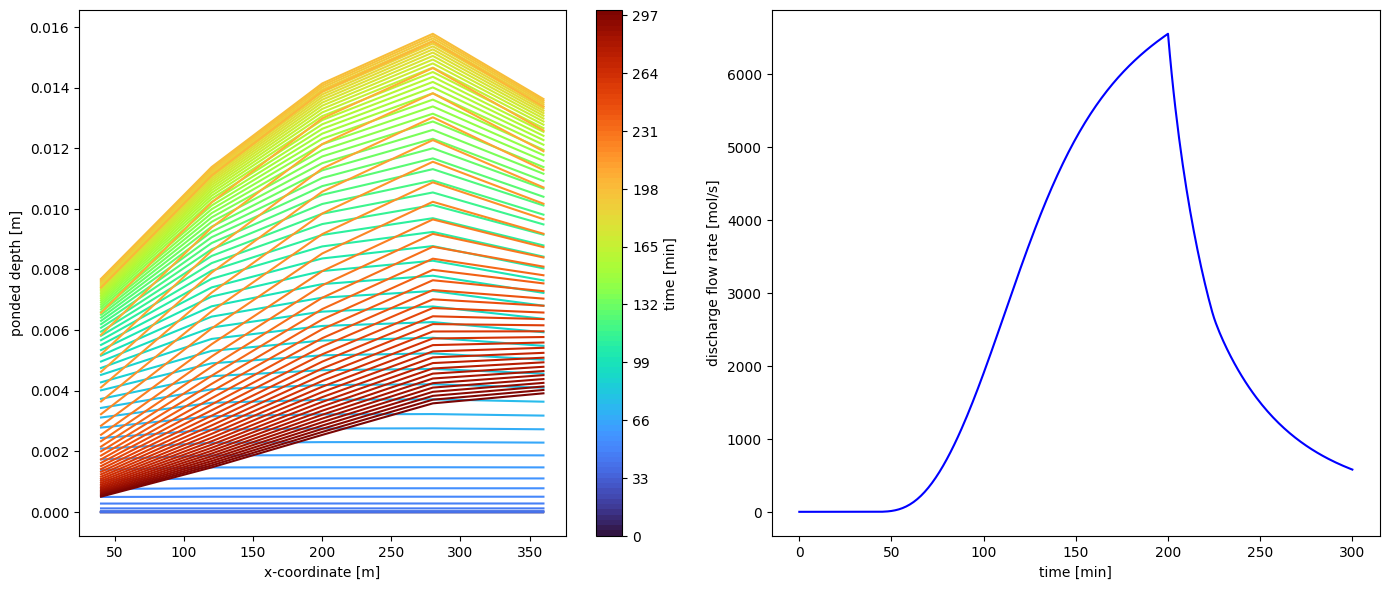

In [22]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

# This simply gets a colorbar axis
C = [[0,0],[0,0]]
C3 = ax[0].contourf(C, vis.times/60, cmap='turbo')
ax[0].cla()  

pd = vis.getArray('surface-ponded_depth')
print(pd.shape)
elev = vis.get('surface-elevation', '0')

#ax[0].plot(x, elev, 'k')
for i in range(num_times):
    #ax[0].plot(x, elev + pd[i,:], color=cm(i))
    ax[0].plot(x, pd[i,:], color=cmap(norm(i)))

ax[0].set_xlabel('x-coordinate [m]')
ax[0].set_ylabel('ponded depth [m]')

hydro = pandas.read_csv(os.path.join(directory, 'surface_outlet_flux.dat'), comment='#')
ax[1].plot(hydro["time [s]"][:]/60.0, hydro["surface outlet flux"][:], 'b')
ax[1].set_xlabel('time [min]')
ax[1].set_ylabel('discharge flow rate [mol/s]')

cbar = plt.colorbar(C3, ax=ax[0])
cbar.ax.set_ylabel("time [min]")

plt.tight_layout()
plt.savefig('HW9_Q4.png', dpi=1200)
plt.show()

## 2D transect of V-catchment 

In the next example, we rain on a transect of a V-catchment in 2D, allowing the water to pond.  This simply demonstrates that water runs downhill (in a coupled environment) and pools on the surface.  The plots show saturation (in colors) in the subsurface and the ponded depth (a line above the catchment).  

At time zero, a water table is established.  Infiltration occurs through the 9 hour plot.  By 12 hours, the domain is saturated and water starts to pond on the surface.

In [23]:
# plot the saturation at a few times
directory = "2d-transect"

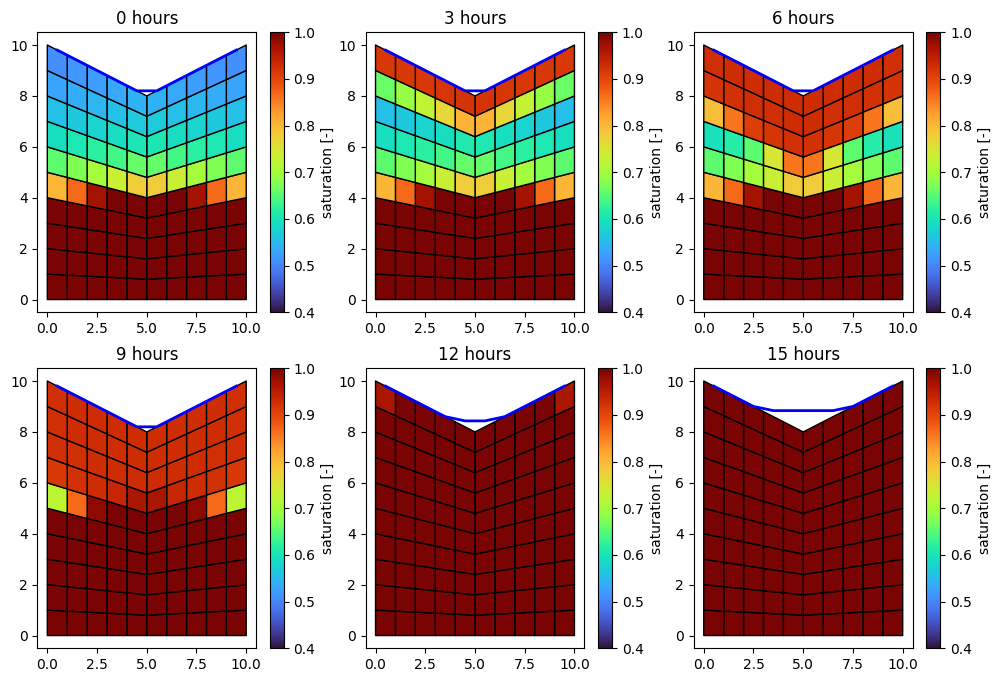

In [24]:
vis = ats_xdmf.VisFile(directory, time_unit='d')
vis.filterIndices(range(0,21,4))
vis.loadMeshPolygons()

vis_surf = ats_xdmf.VisFile(directory, domain='surface', time_unit='d')
vis_surf.filterIndices(range(0,21,4))
vis_surf.loadMesh(order=['x','z'])

fig, axs = plt.subplots(2,3,figsize=(12,8))

def plot(i, ax):
    sat = vis.get("saturation_liquid", vis.cycles[i])
    poly = vis.getMeshPolygons(cmap='turbo', linewidth=1)
    poly.set_array(sat)
    poly.set_clim(0.4,1)
    ax.add_collection(poly)

    elev = vis_surf.get('surface-elevation', vis.cycles[i])
    pd = vis_surf.get('surface-ponded_depth', vis.cycles[i])

    ax.plot(vis_surf.centroids[:,0], elev+pd, 'b', linewidth=2)
    ax.set_title(f"{3*i} hours")

    # Add colorbar explicitly
    cbar = fig.colorbar(poly, ax=ax, orientation='vertical')
    cbar.set_label("saturation [-]")


plot(0, axs[0,0])
plot(1, axs[0,1])
plot(2, axs[0,2])
plot(3, axs[1,0])
plot(4, axs[1,1])
plot(5, axs[1,2])